Entering comparison code
[(0.5691721123565571, u'William J. Clinton', u'Barack Obama'), (0.5421486008128538, u'George Bush', u'Barack Obama'), (0.5240679962256453, u'Ronald Reagan', u'George Bush'), (0.5167849086206793, u'George Bush', u'William J. Clinton'), (0.5132422972792439, u'Ronald Reagan', u'Barack Obama'), (0.49674944504733715, u'Zachary Taylor', u'Millard Fillmore'), (0.4926069209398873, u'Ronald Reagan', u'William J. Clinton'), (0.47680727677036994, u'Dwight D. Eisenhower', u'John F. Kennedy'), (0.436530302633883, u'James K. Polk', u'Millard Fillmore'), (0.43392391146349973, u'Andrew Jackson', u'Martin Van Buren'), (0.43353974877563584, u'Gerald R. Ford', u'Jimmy Carter'), (0.43336949276245934, u'Rutherford B. Hayes', u'Chester A. Arthur'), (0.4221967949030207, u'Benjamin Harrison', u'Grover Cleveland'), (0.420301337734583, u'Chester A. Arthur', u'William Howard Taft'), (0.41815968989517316, u'John F. Kennedy', u'Gerald R. Ford'), (0.41792488766471414, u'Jimmy Carter', u'Ron

/software/spark-2.1-el7-x86_64/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


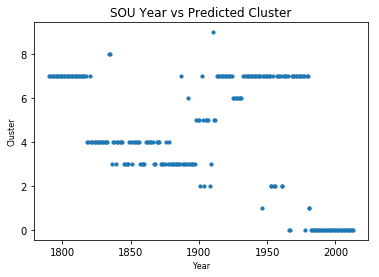

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pylab
import numpy as np
import os
import re
import math
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext

ORDERED_VOCAB_LIST = [] # READ_ONLY after initialization, to get a constant order on the weights vector
MASTER_VOCAB_DICT = {} # READ_ONLY after initialization, maps word -> (num occurences, set(years))
MASTER_DOC_TERMCOUNT_DICT = {} # READ_ONLY after initialization. # maps doc. year -> word -> occurence count

MASTER_WEIGHTS_VECTORS_DICT = {} # READ_ONLY after initialization, maps doc. id -> ([vector], magnitude (of vector))

MASTER_COMPARISON_SCORES_DICT = {} # READ_ONLY after initialization, maps doc. id 1 -> {doc. id 2 -> comparison of 1 and 2} 

NOT_IN_VOCAB_KEY = "NOT_IN_VOCAB"

#### Data generation functions ####

def wordCountFlatMap(row):
    # replace non-alphanumeric with ' ', then split on runs of whitespace
    originating_doc = str(row['year']).strip()
    word_list = re.sub(r"\W+", ' ', row['text']).lower().split()
    
    for i in range(len(word_list)):
        word_list[i] = word_list[i] + originating_doc # encode document year in string 
    # s = s.lower().translate(string.maketrans("",""), string.punctuation)
    return word_list

def wordCountMap(word):
    originating_doc = word[-4:] # retrieve document year
    doc_set = set()
    doc_set.add(originating_doc)
    return (word[:-4], (1, doc_set))

def wordCountReduce(x, y): # to be called with reduce by key
    return (x[0] + y[0], x[1] | y[1]);

def initVocab(wordcount_list): # Should be called only ONCE
    wordcount_list.sort(key = lambda x: x[1][0], reverse=True) # sort by wordcount
    try:
        common_cutoff = 20 - 1 # cutoff most common 20 words
        uncommon_cutoff = 50 # cutoff all words with less than 50 appearances
        for i in range(common_cutoff, len(wordcount_list)):
            if wordcount_list[i][1][0] < uncommon_cutoff: # the list is sorted, so this means we have hit our cutoff
                break
            else:
                MASTER_VOCAB_DICT[wordcount_list[i][0]] = wordcount_list[i][1] # maps word -> (num occurences, set(years))
                ORDERED_VOCAB_LIST.append(wordcount_list[i][0])
        return
                
    except IndexError:
        print "[ERROR]: Data malformed or cutoff bound incorrect."
        
# def initVocabOrder():
#     ORDERED_VOCAB_LIST = MASTER_VOCAB_DICT.keys()
#     return
        
def docOccurenceMap(word): # operates on output from wordCountFlatMap
    originating_doc = word[-4:] # retrieve document year
    occ_dict = {}
    occ_dict[word[:-4]] = 1
    return (originating_doc, occ_dict)

# to be called with reduceByKey, creates dict of form word -> count for a given doc.
# DOES NOT filter on vocabulary
# Fairly efficient, new keys are written only when needed, old values are summed
def docOccurenceReduce(x, y):
    if len(x) > len(y): # we do not want to copy values into the smaller dict from the larger
        for key in y:
            if key in x:
                x[key] += y[key]
            else:
                x[key] = 1
        return x
    else:
        for key in x:
            if key in y:
                y[key] += x[key]
            else:
                y[key] = 1
        return y
    
def initDocTermCounts(doc_wordcount_list):
    for key, wordcount_dict in doc_wordcount_list:
        # this is another dictionary of the form word -> count
        MASTER_DOC_TERMCOUNT_DICT[key] = wordcount_dict
        
    return

def doVectorWeightsMap(word): # operates on output from wordCountFlatMap, returns (doc. year, word -> weight (float)))
    originating_doc = word[-4:] # retrieve document year
    decoded_word = word[:-4]
    return_dict = {}
    if decoded_word in MASTER_VOCAB_DICT: # is the word in the vocabulary
        numOccurencesInDoc = 0
        if decoded_word in MASTER_DOC_TERMCOUNT_DICT[originating_doc]: # is word in document
            numOccurencesInDoc = MASTER_DOC_TERMCOUNT_DICT[originating_doc][decoded_word]
        else: # save ourselves some computation, return 0
            return_dict[decoded_word] = 0.0
            return (originating_doc, return_dict) 
        
        collectionDocTotal = len(MASTER_DOC_TERMCOUNT_DICT)
        numDocsContainingWord = len(MASTER_VOCAB_DICT[decoded_word][1]) # length of the set of all documents which have a term t
        
        weight = 0.0
        if numDocsContainingWord > 0: # safety check, should never fail
            weight = numOccurencesInDoc * math.log(float(collectionDocTotal) / float(numDocsContainingWord))
        else:
            print "ERROR: no documents contain word weight is being calculated for"
        
        return_dict[decoded_word] = weight    
        return (originating_doc, return_dict)
        
    else:
        return_dict[decoded_word] = -1.0
        return (NOT_IN_VOCAB_KEY, return_dict)
    
def doVectorWeightsReduce(x, y): # to be called with reduceByKey
    if len(x) > len(y): # shorter dictionary is used to minimize iterations
        for key in y:
            if key not in x:
                x[key] = y[key]

        return x
    else:
        for key in x:
            if key not in y:
                y[key] = x[key]

        return y

def initWeightVectors(unordered_weights_list):
    for doc_id, weights_dict in unordered_weights_list:
        if doc_id != NOT_IN_VOCAB_KEY:
            vector = []
            for word in ORDERED_VOCAB_LIST:
                try: # order the vectors in some consistent but arbitrary ordering of the vocabulary
                    vector.append(weights_dict[word])
                except KeyError: # attempted to look a word which is in the vocabulary, but not this document
                    # print "[NOTE] attempted to find word " + word + " in weights_dict for year " + \
                    # doc_id + " but failed"
                    vector.append(0.0)

            magnitude = np.linalg.norm(vector)
            MASTER_WEIGHTS_VECTORS_DICT[doc_id] = (vector, magnitude)

    return

#### Data Comparision/Visualization Functions ####

def calculateComparisonsMap(row): # returns a k,v pair of (doc. id 1 -> {doc. id != 1 -> score})
    comparison_dict = {}
    outer_sou_key = row['year'] # only reason we are mapping using the original rdd

    # TODO: create ordered keylist of MASTER_WEIGHTS_VECTORS_DICT? Returning dict so not nessecary?
    for inner_sou_key in MASTER_WEIGHTS_VECTORS_DICT:
        if outer_sou_key != inner_sou_key:
            numerator = np.dot(MASTER_WEIGHTS_VECTORS_DICT[outer_sou_key][0],
                               MASTER_WEIGHTS_VECTORS_DICT[inner_sou_key][0])
            # precomputed magnitudes
            denominator = MASTER_WEIGHTS_VECTORS_DICT[outer_sou_key][1] * \
                          MASTER_WEIGHTS_VECTORS_DICT[inner_sou_key][1]

            comparison_dict[inner_sou_key] = float(numerator) / float(denominator)
                                   
    return (outer_sou_key, comparison_dict)


    
######################################################################################################################

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')
#print df.rdd.flatMap(wordCountFlatMap).map(wordCountMap).collect()
word_rdd = df.rdd.flatMap(wordCountFlatMap)
wordcount_list = word_rdd.map(wordCountMap).reduceByKey(wordCountReduce).collect()
initVocab(wordcount_list) # MASTER_VOCAB_DICT is read_only at this point
# initVocabOrder() # ORDERED_VOCAB_LIST is now read_only
# print MASTER_VOCAB_DICT
doc_wordcount_list = word_rdd.map(docOccurenceMap).reduceByKey(docOccurenceReduce).collect() # term counts per doc
initDocTermCounts(doc_wordcount_list)

unordered_weights_list = word_rdd.map(doVectorWeightsMap).reduceByKey(doVectorWeightsReduce).collect()

initWeightVectors(unordered_weights_list)
# print MASTER_WEIGHTS_VECTORS_DICT
# print 'america' in MASTER_VOCAB_DICT
# print '1830' in MASTER_VOCAB_DICT['america'][1]

########### Comparison code ############
print "Entering comparison code"

# make sure the order of keys is consistent for the double loop. Must be ordered on years
years_list = []
# make sure the order of keys is consistent for the double loop. Must be ordered on year for code to work
pres_list = []

presidential_mapping_dict = {}
for row in df.rdd.collect(): # initialize some helpful data structs
    years_list.append(row['year'])  
    presidential_mapping_dict[row['year']] = row['president']

years_list.sort()
for year in years_list:
    president = presidential_mapping_dict[year]
    if len(pres_list) == 0:
        pres_list.append(president)
    else:
        if pres_list[-1] != president:
#             if president == u'Grover Cleveland' and grover_count == 0: # only president to serve non-continous terms
#                 print "ENTERING GROVER CHECK"
#                 pres_list.append(president)
#                 grover_count = 1
#             else:
            pres_list.append(president)

# print MASTER_WEIGHTS_VECTORS_DICT

comparisons_list = df.rdd.map(calculateComparisonsMap).collect()
for outer_sou_key, comparison_dict in comparisons_list:
    MASTER_COMPARISON_SCORES_DICT[outer_sou_key] = comparison_dict
#     president = presidential_mapping_dict[outer_sou_key]
#     if president not in MASTER_COMPARISON_SCORES_DICT:
#         MASTER_COMPARISON_SCORES_DICT[president] = {}
#         MASTER_COMPARISON_SCORES_DICT[president][outer_sou_key] = comparison_dict
#         comparison_dict
#     else:
        
    
# compare
diff_president_sou = []
same_president_sou = []

averaged_similarity_dict = {}
# NOTE: using indexes so we do not get duplicates in the intermediate results (i.e compare 1900 with 2000, 2000 with 1900)
for i in range(len(years_list)):
    for j in range(i + 1, len(years_list)):
        outer_year = years_list[i]
        inner_year = years_list[j]
        if (outer_year != inner_year):
            outer_president = presidential_mapping_dict[outer_year]
            inner_president = presidential_mapping_dict[inner_year]
            if (outer_president == inner_president): # are presidents the same
                same_president_sou.append((MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year],
                                          (outer_president, outer_year, inner_president, inner_year))) # get comparison scores
            else:
                diff_president_sou.append((MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year],
                                          (outer_president, outer_year, inner_president, inner_year))) # get comparison scores
                                          
                # handle averaging scores between presidents
                if outer_president not in averaged_similarity_dict:
                    averaged_similarity_dict[outer_president] = {}
                if inner_president not in averaged_similarity_dict[outer_president]:
                    averaged_similarity_dict[outer_president][inner_president] = [0.0, 0]
                averaged_similarity_dict[outer_president][inner_president][0] += \
                                          MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year] # update score count
                averaged_similarity_dict[outer_president][inner_president][1] += 1 # update count
                                          

diff_president_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first
same_president_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first


# print averaged_similarity_dict
# print years_list
# print pres_list

avg_presidents_sou = []
for i in range(len(pres_list)):
    for j in range(i + 1, len(pres_list)):
        if (pres_list[i] != pres_list[j]): # handles Grover Cleveland and his non-consecutive terms
            numerator = averaged_similarity_dict[pres_list[i]][pres_list[j]][0]
            denominator = averaged_similarity_dict[pres_list[i]][pres_list[j]][1]
            avg_presidents_sou.append((float(numerator) / float(denominator), pres_list[i], pres_list[j]))
            
avg_presidents_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first

### RESULTS ###
# print diff_president_sou[:50]
# print same_president_sou[:50]
print avg_presidents_sou[:25]


            
print "Exiting comparison code"
# CHECK: Make sure that the below statement is correct
print "It appears that the SOUs tend to rate speeches which are temporally close by as more similar, reflecting what are likely \
similarities in the language and the issues being addressed at those times. \
For better similarity, it may be nessecary to not only consider the frequency of words, but also their relative spacing \
to other words. For example, the fact that a speech mentions America is important, but so is the grammatrical context in which \
it is mentioned in. Grammatical rules, however, are sophisticated, and as such, this is a difficult problem."
############################################################

print "Entering visualization /clustering code"

pre_rdd_list = []
for doc_id in years_list:
    # label = doc_id
    data = MASTER_WEIGHTS_VECTORS_DICT[doc_id][0] # pull out tf-idf weights
    # pre_rdd_list.append(LabeledPoint(label, data))
    pre_rdd_list.append(data)
    

train_data = spark.sparkContext.parallelize(pre_rdd_list, len(pre_rdd_list))

clusters = KMeans.train(train_data, 10, maxIterations=50, runs=10, initializationMode="random")
 
cluster_list = clusters.predict(train_data).collect() # assigned clusters for speech, ordered by speech year 

plt.clf()
plt.figure(1)
 
plt.scatter(years_list, cluster_list, s = 10)
plt.title('SOU Year vs Predicted Cluster', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Cluster', fontsize = 8)
 
plt.show()

spark.stop()
    


In [8]:
import os
import re
from pyspark.sql import SparkSession

def wordCountFlatMap(row):
    # replace non-alphanumeric with ' ', then split on runs of whitespace
    originating_doc = str(row['year']).strip()
    word_list = re.sub(r"\W+", ' ', row['text']).lower().split()
    
    for i in range(len(word_list)):
        word_list[i] = word_list[i] + originating_doc # encode document year in string 
    # s = s.lower().translate(string.maketrans("",""), string.punctuation)
    return word_list

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')
test_string_4 = ""
word_list = []
for row in df.collect():
    if row['year'] == '1836':
        test_string_4 = row['text']
        word_list = wordCountFlatMap(row)
        
tmp1 = test_string_4.lower()
print tmp1.find('america')
print tmp1[2800:2850]
print 'america' in word_list

2830
t of europe.

the claims of american citizens fo
False


In [ ]:
### Part 3 ###

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pylab
import numpy as np
import scipy as sp
import os
import random
import math
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg.distributed import RowMatrix, IndexedRow, IndexedRowMatrix
from pyspark.mllib.feature import PCA

# Globals for visualize()
N_ROWS = 4
N_COLS = 5

NUM_PARTITIONS = 40

# Part 1 functions

# input: subset, an np array where the rows are digits
# input: title, plot title
# inputL savepath, filepath to save plot, Default None if user does not wish to save plot
def visualize(subset, title, savepath=None):
    nrows = 4
    ncols = 5

    plt.clf()
    pylab.figure() # clear plot
    plt.figure(figsize=(N_COLS*2, N_ROWS*2))

    #for i in xrange(nrows*ncols):
    for i in range(len(subset)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(subset[i].reshape((28,28)), cmap='gray')
        plt.axis('off')

    plt.axis('off')
    plt.title(title)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

    return

# Returns every item in rdd with column label affixed in a flat list
def columnFlatMap(row):
    new_row = []
    features = row['features']
    for i in range(len(features)): # i is column index
        feature_list = []
        feature_list.append(features[i])
        new_row.append((i, feature_list))

    return new_row

# to be called with reduce by key
# returns reassembled vectors based on column index
def columnReduce(x, y): 
    if len(x) > len(y):
        for item in y:
            x.append(item)
        return x
    else:
        for item in x:
            y.append(item)
        return y


# Returns summary stats for columns of original data
def centerColumnMap(column):
    column_index = column[0] # get key from previous mapReduce
    mean = np.mean(column[1]) # get features
    std = np.std(column[1], dtype=np.float64)

    return (column_index, (mean, std))

# Returns: centered, UNLABELED data
# NOTE: cannot return labled data otherwise np.svd does not work
def centerMap(row, column_data_dict):
    label = row['label']
    features = row['features']

    centered_features = []
    for i in range(len(features)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((features[i] - mean) / std)
        else:
            centered_features.append(features[i] - mean)

    return centered_features

def centerWithLabelsMap(row, column_data_dict):
    label = row['label']
    features = row['features']

    centered_features = []
    for i in range(len(features)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((features[i] - mean) / std)
        else:
            centered_features.append(features[i] - mean)

    return (label, centered_features)

### Part 2 functions

# num components - num. principal components to be in returned matrix
# input is of shape d * d, where d is the number of columns in the data matrix X
# output is of form k * d, where k is the number of principal components # TODO: Make sure this is correct
def get_pc_matrix(num_components, eigenvectors):
    return eigenvectors[:,:num_components]

# input: principal component matrix, of shape k * d # TODO, make sure this is correct
# output: hat matrix, of shape k * d
def get_hat_matrix(pc_matrix):
    #hat_matrix = np.matmul(np.linalg.inv(np.matmul(pc_matrix, pc_matrix.transpose())), pc_matrix)
    pc_matrix_transpose = pc_matrix.transpose()
    hat_matrix = np.matmul(np.linalg.inv(np.matmul(pc_matrix_transpose, pc_matrix)), pc_matrix_transpose)
    return hat_matrix

# input hat_matrix, of shape k * d
# input point, of shape d * 1
# returns: parameters of projection: of form k * 1
def project_point(hat_matrix, point_t):
    return np.matmul(hat_matrix, point_t)

def stripLabelsMap(row):
    return row['features']

# input principal component matrix, of shape d * k
# projection parameters from project_point, of shape k * 1 
def transform_back_to_d(pc_t_matrix, proj_parameters):
    return np.matmul(pc_t_matrix, proj_parameters)

def projectionErrorMap(row, pc_matrix, hat_matrix):
    proj_parameters = project_point(hat_matrix, np.transpose(row))
    transformed_vector = transform_back_to_d(pc_matrix.transpose(), proj_parameters)

    squared_residual_sum = 0.0
    # calculate projection error
    for i in range(len(row)):
        difference = row[i] - transformed_vector[i]
        squared_residual_sum += (difference * difference)

    return squared_residual_sum

def projectionErrorReduce(x, y):
    return x + y

def predictionLabelReduce(x, y): # To be called with reduceByKey
    if len(x) > len(y):
        for item in y:
            x.append(item)
        return x
    else:
        for item in x:
            y.append(item)
        return y

def kMeansModelMap(row, clusters):
    predicted_label = clusters.predict(row['features'])
    actual_label_list = []
    actual_label_list.append(row['label'])
    return (predicted_label, actual_label_list)

# Part 2/3 K-Means functions
def getClusterLabelsDict(prediction_results):
    cluster_labels_dict = {}
    
    for key, cluster_list in prediction_results: # TODO: can probably combine with for loop below
        most_common_label = max(set(cluster_list), key=cluster_list.count) # get most common label
        cluster_labels_dict[key] = most_common_label
        
    return cluster_labels_dict

def visualizePredictionResults(cluster_labels_dict, prediction_results):
    sample_count = 30 # num samples from each cluster
    for key, cluster_list in prediction_results:
        # sample from cluster, visualize data
        index_set = set()
        for i in range(sample_count):
            rand_indx = random.randint(0, len(cluster_list) - 1)
            while rand_indx in index_set:
                rand_indx = random.randint(0, len(cluster_list) - 1)
            index_set.add(rand_indx)

        subset = []
        majority_count = 0.0
        subset_label = cluster_labels_dict[key] # TODO: the sampling here does not quite work
        for index in index_set:
            subset.append(cluster_list[index])
            if int(cluster_list[index]) == int(subset_label):
                majority_count += 1.0
        key_str = "Cluster num. " + str(key)
        subset_label_str = " has primary label " + str(subset_label)
        subset_str = " : Samples of actual labels from cluster"
        print key_str + subset_label_str + subset_str
        print subset
        print "Percentage majority label: " + str(float(majority_count) / float(sample_count))
        
    return


# Part 3 functions
def similarityMatrixMap(row, h): # NOTE: to be used with uncentered data
    calc_list = []
    for data_vector in row:
        subtraction = np.subtract(data_vector[0], data_vector[1])
        magnitude = np.linalg.norm(subtraction)

        calc_list.append(math.exp((-1.0 * magnitude) / h))

    return calc_list


# NOTE: to be used with uncentered data
def rowSumMap(row):
    return 1.0 / math.sqrt(np.sum(row['features']))

def labelMap(row):
    return row['label']

# Part 4 functions
def labeledPointMap(row):
    label = row['label']
    return LabeledPoint(row['label'], row['features'])

def delabelLabeledPointMap(row):
    return (row.label, row.features)

def errorRateMap(row):
    if int(row[0]) == row[1]:
        return (1, 1)
    else:
        return (0, 1)
def errorRateReduce(x, y):
    return (x[0] + y[0], x[1] + y[1])

def getFeaturesFromLabeledPointMap(row):
    return row.features

def getLabelFromLabeledPointMap(row):
    return row.label

def projectionMap(row, pc_matrix, hat_matrix):
    proj_parameters = project_point(hat_matrix, np.transpose(row))
    transformed_vector = transform_back_to_d(pc_matrix.transpose(), proj_parameters)
    
    return transformed_vector

def unlabeledColumnFlatMap(row):
    new_row = []
    for i in range(len(row)): # i is column index
        feature_list = []
        feature_list.append(row[i])
        new_row.append((i, feature_list))

    return new_row

def unlabeledCenterMap(row, column_data_dict):
    
    centered_features = []
    for i in range(len(row)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((row[i] - mean) / std)
        else:
            centered_features.append(row[i] - mean)

    return centered_features

def labeledPointMap(row):
    return LabeledPoint(row['label'], row['features'])

def zipToLabeledPointMap(row):
    return LabeledPoint(row[0], row[1])
        
############################################################

#os.system('start-spark-slurm.sh&') # use & to put it into background

# get ip address of this machine
ip = os.popen('hostname -i').read().strip('\n')
print 'Spark Master web UI: http://{}:8080'.format(ip)

spark = SparkSession.builder.master('local').appName('assn2').getOrCreate()
# spark = SparkSession.builder.appName("mnist").getOrCreate()
# df = spark.read.json('/project/cmsc25025/mnist/data.json') # TODO IMPORTANT CHANGED FOR DEBUG.
df = spark.read.json('/project/cmsc25025/mnist/data.json').repartition(NUM_PARTITIONS) # TODO IMPORTANT CHANGED FOR DEBUG.
'''
# part 1
print "Entering part 1"
# a)
column_data_dict = {} # indexed by column index
column_data = df.rdd.flatMap(columnFlatMap).reduceByKey(columnReduce).map(centerColumnMap).collect()
for key, value in column_data:
    column_data_dict[key] = value

centered_data_rdd = df.rdd.map(lambda row: centerMap(row, column_data_dict))
centered_train, centered_dev, centered_test = centered_data_rdd.randomSplit([4, 1, 1])

# # need data to be unlabeled for this part
# Cov Matrix
mat = RowMatrix(centered_data_rdd)
cov_matrix = mat.computeCovariance().toArray()
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

components_to_visualize = 10
visualization_subset = []
for i in range(0, components_to_visualize):
    pc = eigen_vectors[:,i]
    visualization_subset.append(pc)

# VISUALIZATION
visualize(visualization_subset, title = "Top 10 principal components")

#b)
y_vector = []

for var in eigen_values:
    y_vector.append(var) 

x_vector = range(1, len(y_vector) + 1)  
plt.clf()
pylab.figure()
plt.title("variance for each principal component")
plt.plot(x_vector, y_vector)
plt.show()

#c)
components_to_test = 100 # test first x principal components
pc_matrix_arr = []
for i in range(10, components_to_test + 1, 10):
    pc_matrix = get_pc_matrix(i, eigen_vectors)
    pc_matrix_arr.append(pc_matrix)

# VISUALIZATION
num_to_sample = 10
sample = centered_test.takeSample(False, num_to_sample, seed=0)
point_arr = []
for row in sample:
    point_arr.append(np.transpose(row))

store = []
for point_t in point_arr:
    substore = []
    num_components = 1
    sub_title = "Num. principal components: " + str(num_components)
    for pc_matrix in pc_matrix_arr:
        hat_matrix = get_hat_matrix(pc_matrix)
        proj_parameters = project_point(hat_matrix, point_t)
        substore.append(transform_back_to_d(pc_matrix, proj_parameters))
    store.append((substore, sub_title))
    num_components += 1

# visualize the elements in store, which are points -> [projections onto first k prin. components]
for substore, sub_title in store:
    visualize(substore, sub_title)


#d)
results_dict = {}
for i in range(10, components_to_test + 1, 10):
    index = (i - 1) / 10
    print "Getting results for component " + str(i)
    hat_matrix = get_hat_matrix(pc_matrix_arr[index])
    results_dict[index] = centered_test.map(lambda row:\
                                        projectionErrorMap(row, pc_matrix_arr[index].transpose(), hat_matrix)).\
                                        reduce(projectionErrorReduce)

# VISUALIZATION
x_vector = np.arange(10, components_to_test + 1, 10)
y_vector = []
for i in range(10, components_to_test + 1, 10):
    index = (i - 1) / 10
    y_vector.append(results_dict[index])

plt.clf()
pylab.figure() 
plt.title("Projection Error per Num of Principal Components")
plt.plot(x_vector, y_vector)
plt.show()
'''

### Part 2 ###
print "Entering part 2"
#centered_data_rdd = df.map(lambda row: centerWithLabelsMap(row, column_data_dict)) TODO: Maybe use this?

#clusters = KMeans.train(centered_data_rdd, 10, maxIterations=50, runs=10, initializationMode="random")
#predicted_rdd = clusters.predict(centered_data_rdd)
p2_train = df

label_list = p2_train.rdd.map(labelMap).collect()

data_rdd = p2_train.rdd.map(stripLabelsMap)
clusters = KMeans.train(data_rdd, 10, maxIterations=50, runs=10, initializationMode="random")
    
prediction_results = p2_train.rdd.map(lambda row: kMeansModelMap(row, clusters)).reduceByKey(predictionLabelReduce).collect()
cluster_labels_dict = getClusterLabelsDict(prediction_results) # maps cluster index to most common label in that cluster
visualizePredictionResults(cluster_labels_dict, prediction_results)

### Part 3 ###
print "Entering part 3"
h = 5.0
# From Piazza post only using 10K images
p3_subset, p3_test = df.rdd.randomSplit([1,99])

# possible to filter duplicate cross products
similarity_matrix = p3_subset.cartesian(p3_subset).flatMap(lambda row: similarityMatrixMap(row, h))

dim = similarity_matrix.count()
# http://stackoverflow.com/questions/42118005/create-an-identity-matrix-of-densevectors-as-a-spark-dataframe
identity_matrix = np.identity(dim)
diag_sim_matrix = np.diag(similarity_matrix.map(rowSumMap).collect())
print(diag_sim_matrix[0:10,0:10])
sym_laplacian = np.subtract(identity_matrix,
                            np.matmul(np.matmul(diag_sim_matrix, similarity_matrix), diag_sim_matrix))

highest_eigenval = sp.eigh(sym_laplacian, eigs_only=True, eigs=(0,0))[0] #changed to scipy eig

scalar_diag_matrix = np.multiply(highest_eigenval, identity_matrix)
num_vectors = range(2, 3 + 1, 1)

for i in num_vectors:
    pca = PCA(k=i)
    pca_model = pca.fit(np.subtract(scalar_diag_matrix, sym_laplacian))

    projected_data_rdd = pca_model.transform(p3_subset) # CHECK: make sure this works on labeled data
    projected_cluster_model = KMeans.train(projected_data_rdd, 10, maxIterations=50, runs=10, initializationMode="random")
    # Check this
    prediction_results = projected_cluster_model.predict(projected_data_rdd)

    print "Visualizing results for " + i + " eigenvectors"
    visualizePredictionResults(cluster_labels_dict, prediction_results)


### Part 4 ###
print "Entering Part 4"

# part a
labeledPointRDD = df.map(labeledPointMap)
labeled_train, labeled_dev, labeled_test = labeledPointRDD.randomSplit([4, 1, 1])

num_iterations = 50
num_digits = 10 # 10 digits
model = LogisticRegressionWithLBFGS.train(labeled_train, iterations=num_iterations, numClasses=num_digits)

log_reg_results = labeled_test.map(lambda point: (point.label, model.predict(point.features))).map(errorRateMap).reduce(errorRateReduce)
error_rate = 1.0 - (float(log_reg_results[0]) / float(log_reg_results[1]))
print "Error rate for full features: " + str(error_rate)

# part b

results_dict = {}
k_range = range(1, 50, 5)
for k in range(k_range):
    pca_model = PCA(k).fit(labeled_train) # Check: make sure this works
    projected_train_rdd = pca_model.transform(labeled_rdd)

    num_iterations = 50
    num_digits = 10 # 10 digits
    model = LogisticRegressionWithLBFGS.train(projected_train_rdd, iterations=num_iterations, numClasses=num_digits)
    log_reg_results = labeled_test.map(lambda point: (point.label, model.predict(point.features))).\
                                    map(errorRateMap).reduce(errorRateReduce)
    error_rate = 1.0 - (float(log_reg_results[0]) / float(log_reg_results[1]))
    results_dict[k] = error_rate
    print "Error rate for " + str(k) + ": " + str(error_rate)

# part c:
lowest_pc_error = 1.1
lowest_pc_key = 0.0
for key, value in results_dict.items():
    if value < lowest_pc_error:
        lowest_pc_error = value
        lowest_pc_key = key

num_iterations = 50
num_digits = 10 # 10 digits

train_pca_model = PCA(lowest_pc_key).fit(labeled_train) # Check: make sure this works
projected_train_rdd = pca_model.transform(labeled_rdd)
train_model = LogisticRegressionWithLBFGS.train(projected_train_rdd, iterations=num_iterations, numClasses=num_digits)
train_log_reg_results = labeled_test.map(lambda point: (point.label, train_model.predict(point.features))).\
                                    map(errorRateMap).reduce(errorRateReduce)
train_error_rate = 1.0 - (float(train_log_reg_results[0]) / float(train_log_reg_results[1]))
print "Error rate for model trained on training data" + str(lowest_pc_key) + ": " + str(error_rate)

dev_pca_model = PCA(lowest_pc_key).fit(labeled_dev) # Check: make sure this works
projected_dev_rdd = dev_pca_model.transform(labeled_dev)
dev_model = LogisticRegressionWithLBFGS.train(projected_dev_rdd, iterations=num_iterations, numClasses=num_digits)

dev_log_reg_results = labeled_test.map(lambda point: (point.label, dev_model.predict(point.features))).\
                                    map(errorRateMap).reduce(errorRateReduce)
test_error_rate = 1.0 - (float(test_log_reg_results[0]) / float(test_log_reg_results[1]))
print "Error rate for model trained on testing data" + str(lowest_pc_key) + ": " + str(error_rate)

spark.stop()
os.system('stop-spark-slurm.sh')

Spark Master web UI: http://10.50.221.198:8080
Entering part 2


/software/spark-2.1-el7-x86_64/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Cluster num. 0 has primary label 7 : Samples of actual labels from cluster
[7, 9, 4, 9, 4, 9, 7, 7, 7, 7, 7, 4, 9, 7, 9, 9, 8, 9, 4, 7, 4, 4, 7, 8, 9, 9, 7, 7, 9, 7]
Percentage majority label: 12.0
Cluster num. 1 has primary label 3 : Samples of actual labels from cluster
[5, 3, 3, 3, 6, 3, 3, 3, 3, 8, 0, 0, 3, 3, 5, 3, 3, 3, 2, 5, 3, 0, 8, 8, 3, 5, 0, 3, 5, 3]
Percentage majority label: 16.0
Cluster num. 2 has primary label 6 : Samples of actual labels from cluster
[6, 6, 6, 6, 6, 6, 6, 2, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0]
Percentage majority label: 26.0
Cluster num. 3 has primary label 4 : Samples of actual labels from cluster
[2, 4, 4, 2, 7, 7, 3, 4, 4, 8, 4, 4, 5, 4, 9, 4, 8, 4, 1, 7, 4, 7, 7, 4, 4, 6, 9, 2, 9, 9]
Percentage majority label: 12.0
Cluster num. 4 has primary label 8 : Samples of actual labels from cluster
[8, 8, 8, 5, 5, 8, 7, 8, 8, 5, 3, 3, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 2, 8, 8, 8, 5, 3, 5, 8]
Percentage majority label: 18.0
Cluster nu